Using 20000 images for training and testing.
Using device cuda
Number of parameters in the model: 111218
Searching for jpg files in directory: data/Fire_Detection.v1.coco/train/
Found 8939 jpg files in directory: data/Fire_Detection.v1.coco/train/
Number of fire images: 8939
Number of no fire images: 8939
Searching for jpg files in directory: data/data_256
Found 1803460 jpg files in directory: data/data_256
12000


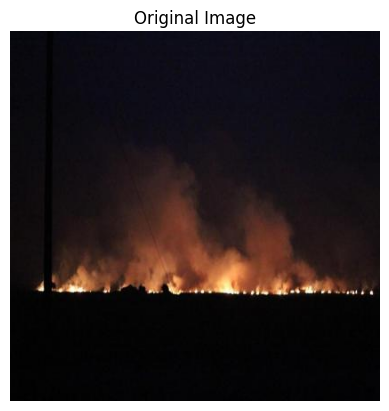

In [1]:

from train_cnn import TrainingModel, train_cnn, TRANSFORM, ModelWithTransform, get_image_data, visualize_loss_curve, visualize_layer_weights, TrainingParameters
import torch
import matplotlib.pyplot as plt
n_samples = 20000
output_file_path = "test_model.pth"

print(f"Using {n_samples} images for training and testing.")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device {DEVICE}")
model = TrainingModel()

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
training_params = TrainingParameters(
        optimizer=optim,
        loss_function=torch.nn.BCEWithLogitsLoss(), # Binary Classification Loss that automatically applies sigmoid
        batch_size=128,
        n_epochs=10,
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', patience=5, factor=0.5), # reduce learning reate by half if no improvement in 5 epochs
        early_stopping_threshold=1e-5,
        device = DEVICE
    )

# resize to 224x224 as preprocessing step
model_and_transform = ModelWithTransform(model, TRANSFORM)

train,val,test = get_image_data(n_samples)

print(len(train))

random_fire_img = None
for i in range(0, len(train)):
    if train[i][1]:
        random_fire_img = train[i][0]
        break

if random_fire_img is None:
    raise ValueError("No fire image found in the training set.")


# show original image
plt.imshow(random_fire_img.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')
plt.title("Original Image")
plt.show()

random_fire_img = TRANSFORM(random_fire_img)




In [2]:


train_loss, val_loss ,fire_detector = train_cnn(model_and_transform,training_params,train, val)
# Save the trained model to a file
fire_detector.save_to_file(output_file_path)
print(f"Model saved to {output_file_path}")




Begin training...
Epoch 1 completed. Train loss: 0.5243, Validation loss: 0.4063
Epoch 2 completed. Train loss: 0.3725, Validation loss: 0.3731
Epoch 3 completed. Train loss: 0.3393, Validation loss: 0.3583
Epoch 4 completed. Train loss: 0.3213, Validation loss: 0.3381
Epoch 5 completed. Train loss: 0.3114, Validation loss: 0.3296
Epoch 6 completed. Train loss: 0.2914, Validation loss: 0.3185
Epoch 7 completed. Train loss: 0.2801, Validation loss: 0.3073
Epoch 8 completed. Train loss: 0.2637, Validation loss: 0.3691
Epoch 9 completed. Train loss: 0.2424, Validation loss: 0.2998
Epoch 10 completed. Train loss: 0.2248, Validation loss: 0.3428
Model saved to test_model.pth


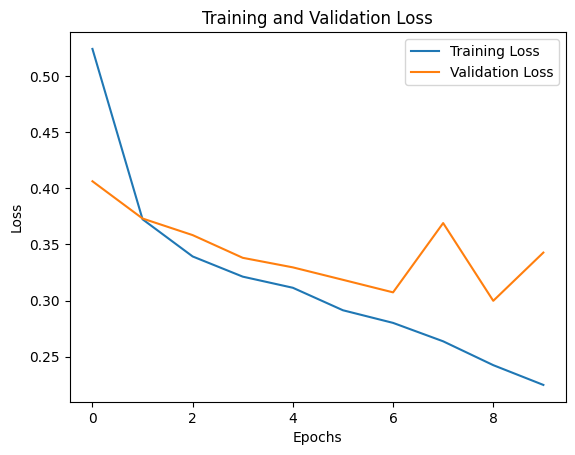

In [3]:
visualize_loss_curve(train_loss, val_loss)



Filters shape:  torch.Size([16, 3, 5, 5])
torch.Size([16, 3, 5, 5])


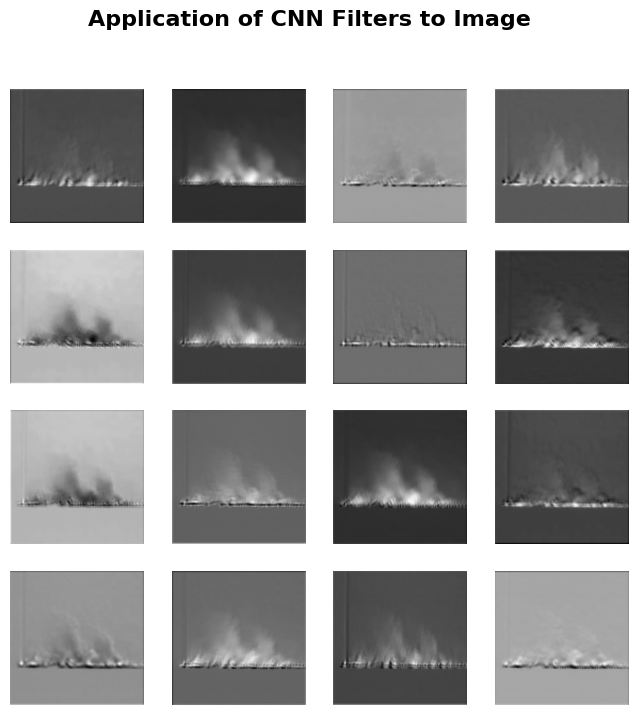

In [4]:
visualize_layer_weights(fire_detector.model.trained_model.convolutional_layers[0], random_fire_img)
